# Hackathon Semi-Final Round Code

This codebook is the solution that I implemented for the problem ID AQVH917 at the Amaravati Quantum Valley Hackathon 2025. The problem statement was 'Classify future market direction with VQC' under the theme 'Quantum ML: FTSE 100 Forecasting'. Now, I did not use the FTSE 100 data but instead I used the NSE data of RELIANCE. The results are pathetic but it still won the first prize due to approaching the problem in a unique way. All quantum computing related code was written using the Qiskit library in Python.

In [30]:
# !pip install openchart
# !pip install numpy
# !pip install pandas
# !pip install qiskit
# !pip install qiskit-aer
# !pip install qiskit-algorithms
# !pip install qiskit-machine-learning
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn

In [2]:
# Import necessary libraries
from openchart import NSEData
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit_aer import Aer , AerSimulator
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_algorithms.optimizers import COBYLA,SPSA, L_BFGS_B, ADAM
from qiskit.primitives import Sampler, Estimator
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Creating the quantum reservoir

theta_1 = np.pi / 6
theta_2 = np.pi / 4
reservoir_depth = 30
qubits=4

# The quantum reservoir is made from angle encoding.
def quantum_reservoir(data_point, qubits, theta_1, theta_2 , reservoir_depth=5, seed=42):
    np.random.seed(seed)

    reservoir_circuit = QuantumCircuit(qubits)

    for i , value in enumerate(data_point):
        reservoir_circuit.h(i)
        reservoir_circuit.rx(2 * np.pi * value, i)
        reservoir_circuit.ry(np.pi * value, i)
        reservoir_circuit.rz(3 * np.pi * value, i)


    for _ in range(reservoir_depth):
        for qubit in range(qubits):
            reservoir_circuit.ry(np.random.uniform(0, np.pi), qubit)

        for qubit in range(qubits-1):
            reservoir_circuit.cx(qubit, qubit+1)

        for qubit in range(qubits-2):
            reservoir_circuit.crx(theta_1, qubit, qubit+1)
            reservoir_circuit.crz(theta_2, qubit+1, qubit+2)

    reservoir_circuit.measure_all()
    reservoir_circuit.draw(output='mpl')

    return reservoir_circuit

# Using the reservoir for extracting the features.
def extract_features(data, qubits):
    # data=data.to_numpy()
    features = []
    for data_point in data:
        reservoir_circuit = quantum_reservoir(data_point, qubits, theta_1, theta_2 , reservoir_depth)

        simulator = AerSimulator()
        transpiled_circuit = transpile(reservoir_circuit, simulator)
        job = simulator.run(transpiled_circuit, shots=1024)
        result = job.result()
        counts = result.get_counts()


        feature_vector = [counts.get(f"{i:0{qubits}b}", 0) / 1024 for i in range(2**qubits)]
        features.append(feature_vector)


    return np.array(features)

In [28]:

# Step 1: Define a function to build the QRC feature map
def qrc_feature_map(qubits):
    theta_1=np.pi/6
    theta_2=np.pi/4
    reservoir_depth = 5
    seed=42

    np.random.seed(seed)

    # Create symbolic parameters for inputs
    x = ParameterVector("x", length=qubits)
    qc = QuantumCircuit(qubits)

    # Input encoding
    for i in range(qubits):
        qc.h(i)
        qc.rx(2 * np.pi * x[i], i)
        qc.ry(np.pi * x[i], i)
        qc.rz(3 * np.pi * x[i], i)

    # Reservoir dynamics
    for _ in range(reservoir_depth):
        # Random rotations
        for qubit in range(qubits):
            qc.ry(np.random.uniform(0, np.pi), qubit)

        # Entanglement with CNOTs
        for qubit in range(qubits - 1):
            qc.cx(qubit, qubit + 1)

        # Controlled rotations
        for qubit in range(qubits - 2):
            qc.crx(theta_1, qubit, qubit + 1)
            qc.crz(theta_2, qubit + 1, qubit + 2)

    qc.draw(output='mpl')

    return qc, x


In [5]:
# Obtaining the NSE meta data
nse=NSEData()
nse.download()

NSE data shape: (3189, 4)
NFO data shape: (85292, 4)
NSE and NFO data downloaded successfully.


In [ ]:
# Downloading the NSE data of RELIANCE and creating additional features. 

end_date=datetime.datetime.now()
start_date=end_date-datetime.timedelta(days=30)

data=nse.historical(
    symbol='RELIANCE',
    exchange='NSE',
    start=start_date,
    end=end_date,
    interval='1m'
)

data.columns=data.columns.str.lower()

trend=[]
open=data['open'].to_list()
close=data['close'].to_list()

for i in range(len(data)):
    if close[i]-open[i]>0:
        trend.append(1)
    else:
        trend.append(0)

data['trend']=trend

data['lag1']=data['close'].shift(1)
data['lag2']=data['close'].shift(2)

data["rolling_mean5"] = data["close"].rolling(5).mean()
data["rolling_std5"] = data["close"].rolling(5).std()

data=data.dropna()

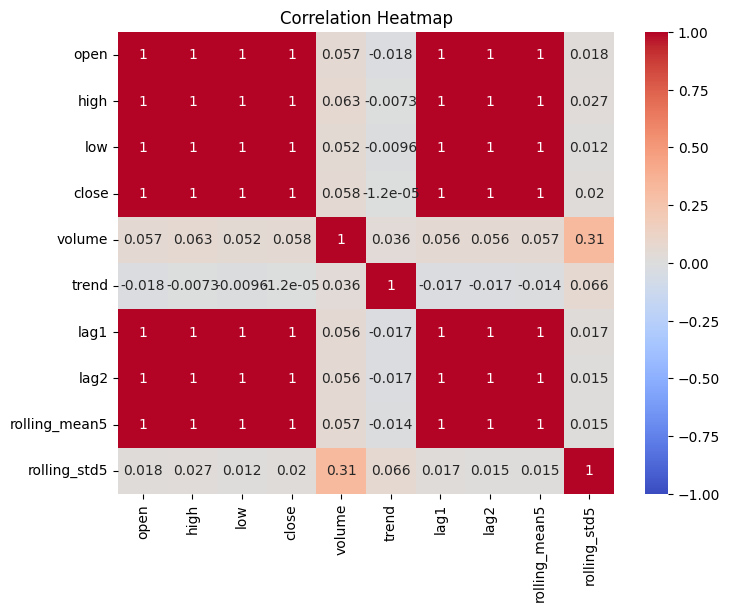

In [ ]:
# Creating a correlation heatmap to observe the correlation among the features. 

data.columns=data.columns.str.lower()
corr_matrix=data.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [8]:
#  For trend prediction
X=data[['lag1','lag2','rolling_mean5','rolling_std5']]      # 'open','high','low','volume',
y=data['trend']
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8,random_state=42)

X_train=X_train.to_numpy()
X_train=X_train[len(X_train)-200:len(X_train)-1]

y_train=y_train.to_numpy()
y_train=y_train[len(y_train)-200:len(y_train)-1]

X_test=X_test.to_numpy()
X_test=X_test[len(X_test)-100:len(X_test)-1]

y_test=y_test.to_numpy()
y_test=y_test[len(y_test)-100:len(y_test)-1]

In [9]:
len(y_train)

199

In [10]:
# Build feature map and ansatz
feature_map, feature_params = qrc_feature_map(qubits=4)

# Creating an ansatz
ansatz=RealAmplitudes(num_qubits=4)

# Creating an optimizer
optimizer=COBYLA(maxiter=5)

# Ansatz circuit (trainable part)
ansatz = TwoLocal(qubits, ['ry', 'rz'], 'cz', reps=2)

# Define optimizer and primitives
optimizer = COBYLA(maxiter=200)
# sampler = Sampler(run_options={"method": "statevector"})

# VQC model
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer #,
    # sampler=sampler
)


In [11]:
vqc.fit(X_train,y_train)
vqc.score(X_train,y_train)

0.6834170854271356

In [12]:
predictions=vqc.predict(X_test)

accuracy=0

for i in range(len(predictions)):
    if y_test[i]==predictions[i]:
        accuracy+=1

accuracy=float(accuracy/len(predictions))*100

print('Testing Accuracy: '+str(accuracy))

Testing Accuracy: 46.464646464646464


In [13]:
# For price predictions
X=data[['lag1','lag2','rolling_mean5','rolling_std5']]
y=data['close']
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8,random_state=42)

X_train=X_train.to_numpy()
X_train=X_train[len(X_train)-200:len(X_train)-1]

y_train=y_train.to_numpy()
y_train=y_train[len(y_train)-200:len(y_train)-1]

X_test=X_test.to_numpy()
X_test=X_test[len(X_test)-100:len(X_test)-1]

y_test=y_test.to_numpy()
y_test=y_test[len(y_test)-100:len(y_test)-1]



In [14]:
# Build feature map and ansatz
feature_map, feature_params = qrc_feature_map(qubits=4)

# Creating an ansatz
ansatz=RealAmplitudes(num_qubits=4)

# Creating an optimizer
optimizer=COBYLA(maxiter=5)

# Ansatz circuit (trainable part)
ansatz = TwoLocal(qubits, ['ry', 'rz'], 'cz', reps=2)

# Define optimizer and primitives
optimizer = COBYLA(maxiter=200)

# Create VQR model
vqr = VQR(
    feature_map=feature_map, ansatz=ansatz,
    optimizer=optimizer, loss='squared_error',
)

vqr.fit(X_train,y_train)
print(vqr.score(X_train,y_train))

# Predictions using VQR
predictions=vqr.predict(X_test)

print("MSE:", mean_squared_error(y_test, predictions))
print("R²:", r2_score(y_test, predictions))

-3356.9796549572
MSE: 2361883.447232572
R²: -3858.1777657599064


# Using Classical Models

In [15]:
# QRC Separate:
X_train_qrc=extract_features(X_train,qubits=4)
X_test_qrc=extract_features(X_test,qubits=4)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train_qrc, y_train)

preds = model.predict(X_test_qrc)

print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))


MSE: 712.542785307236
R²: -0.1642527396651623


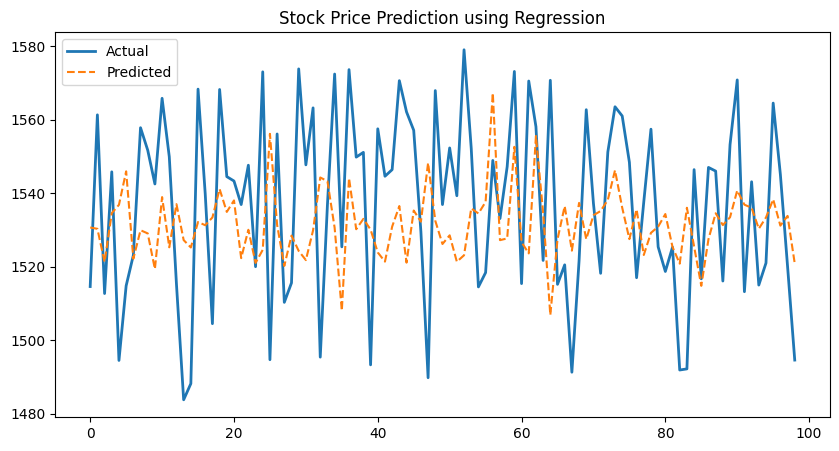

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(preds, label="Predicted", linestyle="--")
plt.legend()
plt.title("Stock Price Prediction using Regression")
plt.show()


In [17]:
# No QRC but normalized

X=data[['lag1','lag2','rolling_mean5','rolling_std5']]
y=data['close']
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8,random_state=42)

scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_train=X_train[len(X_train)-200:len(X_train)-1]

y_train=y_train.to_numpy()
y_train=y_train[len(y_train)-200:len(y_train)-1]

X_test=X_test.to_numpy()
X_test=scaler.fit_transform(X_test)
X_test=X_test[len(X_test)-100:len(X_test)-1]

y_test=y_test.to_numpy()
y_test=y_test[len(y_test)-100:len(y_test)-1]

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))

MSE: 0.6767836943984186
R²: 0.998894175498494


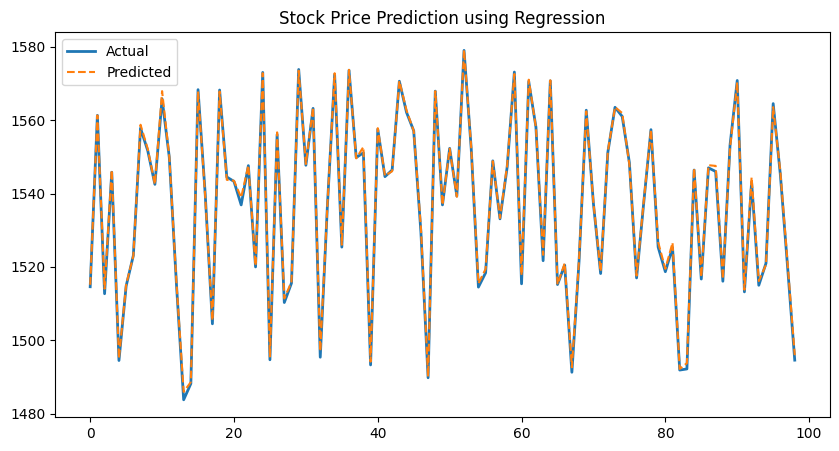

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(preds, label="Predicted", linestyle="--")
plt.legend()
plt.title("Stock Price Prediction using Regression")
plt.show()


In [ ]:
# Using Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=4)
X_poly=poly.fit_transform(X_train_qrc)

model.fit(X_poly,y_train)

X_poly_test= poly.fit_transform(X_test_qrc)
preds = model.predict(X_poly_test)

print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))


MSE: 3696.34895160288
R²: -5.039615420155458


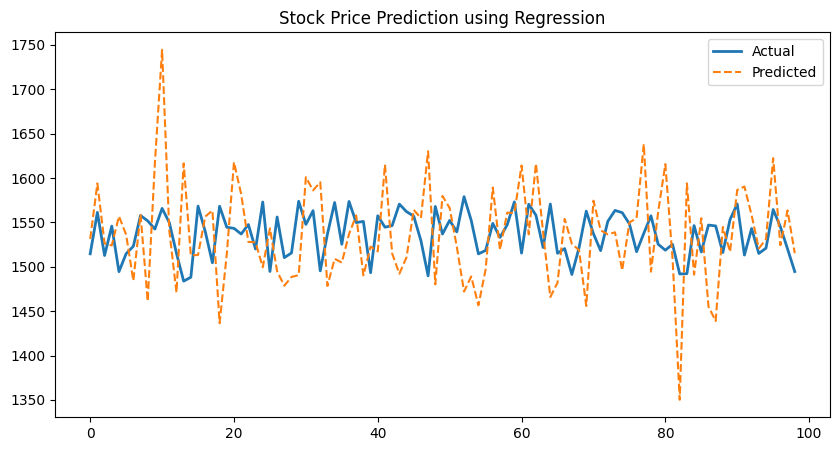

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(preds, label="Predicted", linestyle="--")
plt.legend()
plt.title("Stock Price Prediction using Regression")
plt.show()


In [21]:
# No QRC but normalized

X=data[['lag1','lag2','rolling_mean5','rolling_std5']]
y=data['close']
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8,random_state=42)

scaler=StandardScaler()

X_train=scaler.fit_transform(X_train)
X_train=X_train[len(X_train)-200:len(X_train)-1]

y_train=y_train.to_numpy()
y_train=y_train[len(y_train)-200:len(y_train)-1]

X_test=X_test.to_numpy()
X_test=scaler.fit_transform(X_test)
X_test=X_test[len(X_test)-100:len(X_test)-1]

y_test=y_test.to_numpy()
y_test=y_test[len(y_test)-100:len(y_test)-1]

from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=4)
X_poly=poly.fit_transform(X_train)

model.fit(X_poly,y_train)

X_poly_test= poly.fit_transform(X_test)
preds = model.predict(X_poly_test)

print("MSE:", str(mean_squared_error(y_test, preds)))
print("R²:", r2_score(y_test, preds))


MSE: 172.79481759423297
R²: 0.7176634948352136


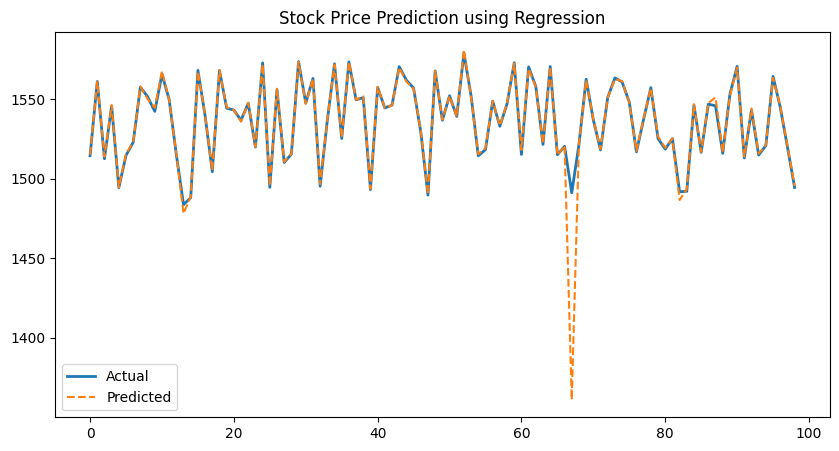

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(preds, label="Predicted", linestyle="--")
plt.legend()
plt.title("Stock Price Prediction using Regression")
plt.show()
